# Setting up a basic ReAct Agent in LangGraph

In [48]:
import os

os.environ["OPENAI_API_KEY"] = 'sk-***'
os.environ["SERPAPI_API_KEY"] = 's***'  # https://serpapi.com for a free token!

In [3]:
# A way to get a tool from langchain

from langchain_community.agent_toolkits.load_tools import load_tools
tools = load_tools(["serpapi"])

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
tools[0].run('sinan ozdemir')

'["Sinan Ozdemir is an AI expert, educator, and entrepreneur with an master\'s degree in pure mathematics from Johns Hopkins University, where he also lectured. ...", \'Sinan Ozdemir type: Author.\', \'Sinan Ozdemir entity_type: people.\', \'Sinan Ozdemir kgmid: /g/11hcjs9cr6.\', \'Specialized in areas including time management as well as mathematics and computer science logistics.\', \'Helping companies leverage AI technology to solve complex problems. Founder, author, and consultant specializing in AI, LLMs, and data science.\', \'Data Scientist + Author + Entrepreneur. Check out my new book on LLMs on Amazon (Top 10 in AI/NLP) - sinanuozdemir.\', \'Sinan Ozdemir (@Prof_OZ) - Posts - NLP + Gen AI Expert / LLM whisperer AI Author Founder @Aikylie (acquired) Contributor on ... | X (formerly Twitter)\', "A beginner\'s guide to essential math and coding skills for data fluency and machine learning by Sinan Ozdemir", \'Sinan is a former lecturer of Data Science at Johns Hopkins University

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.agents import create_agent
from datetime import date
from langgraph.checkpoint.memory import MemorySaver

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4.1-mini")
agent_executor = create_agent(
    llm, tools, 
    state_modifier=f'Today is {str(date.today())}',
    checkpointer=MemorySaver()
)

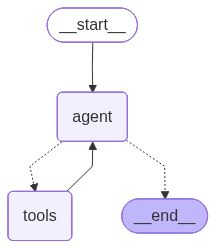

In [54]:
# Compile the graph
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

# Bringing MCP into the mix

In [55]:
# Import necessary libraries
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from langchain_mcp_adapters.tools import load_mcp_tools
from langgraph.prebuilt import create_react_agent
import nest_asyncio

# Apply nest_asyncio to handle nested event loops
nest_asyncio.apply()

In [70]:
import os

# Note this is NOT an production ready MCP server, don't include env variables this way. 
#  I'm doing this so I can work in a notebook
MCP_SERVER = f'''
from mcp.server.fastmcp import FastMCP
from langchain_community.utilities import SerpAPIWrapper
import os

mcp = FastMCP("MCP Example")

@mcp.tool()
def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b

@mcp.tool()
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b

@mcp.tool()
def google_something(query: str) -> str:
    """Online Realtime Web Search"""
    serpapi = SerpAPIWrapper(serpapi_api_key="{os.getenv("SERP_API_KEY")}")
    return serpapi.run(query)

if __name__ == "__main__":
    mcp.run(transport="stdio")
'''

mcp_path = 'mcp_server.py'

with open(mcp_path, 'w') as f:
    f.write(MCP_SERVER)

print("Saved to:", os.path.abspath(mcp_path))


Saved to: /Users/sinanozdemir/Teaching/Pearson/oreilly-ai-agents/notebooks/mcp_server.py


In [73]:
import sys
from langchain_openai import ChatOpenAI
from mcp import ClientSession, StdioServerParameters
llm = ChatOpenAI(model="gpt-4.1-mini")

server_params = StdioServerParameters(
    command=sys.executable,
    args=[os.path.abspath(mcp_path)]
)

async def agent_run_async(m, thread_id="thread_id"):
    async with stdio_client(server_params) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            mcp_tools = await load_mcp_tools(session)
            for tool in mcp_tools:
                print(f'Tool Name: {tool.name}')
                print(f'Tool Description: {tool.description}')
                print(f'Tool Args Schema: {tool.args_schema}')
                print(f'Tool Args : {tool.response_format}')
                print('------')
            agent = create_react_agent(
                llm, mcp_tools,
                checkpointer=MemorySaver()
            )
            response = await agent.ainvoke(
                {"messages": m}, config={"configurable": {"thread_id": thread_id}}
            )
            return response

In [74]:
agent_response = await agent_run_async("what's the current price of bitcoin times 12?", thread_id='my test')

Tool Name: add
Tool Description: Add two numbers
Tool Args Schema: {'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'addArguments', 'type': 'object'}
Tool Args : content_and_artifact
------
Tool Name: multiply
Tool Description: Multiply two numbers
Tool Args Schema: {'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'multiplyArguments', 'type': 'object'}
Tool Args : content_and_artifact
------
Tool Name: google_something
Tool Description: Online Realtime Web Search
Tool Args Schema: {'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'google_somethingArguments', 'type': 'object'}
Tool Args : content_and_artifact
------


In [75]:
agent_response['messages'][-1]

AIMessage(content='The current price of Bitcoin is approximately $113,860.58. When multiplied by 12, it equals $1,366,320.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 157, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6d7dcc9a98', 'id': 'chatcmpl-CLBkwE8U7aGkdn40bBQX0JPvRh0Wr', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3b1ea9e3-1e12-4bd3-89b0-87346412da4a-0', usage_metadata={'input_tokens': 157, 'output_tokens': 30, 'total_tokens': 187, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [78]:
for message in agent_response['messages']:
    print(type(message), message.content, 'Tool ID:' + message.tool_call_id if hasattr(message, 'tool_call_id') else '')
    if message.additional_kwargs.get('tool_calls'):
        for tool_call in message.additional_kwargs.get('tool_calls'):
            print(f'Tool Call: ID({tool_call["id"]}), Name({tool_call["function"]["name"]}), Args({tool_call["function"]["arguments"]})')
    print('----')

<class 'langchain_core.messages.human.HumanMessage'> what's the current price of bitcoin times 12? 
----
<class 'langchain_core.messages.ai.AIMessage'>  
Tool Call: ID(call_S3MXyjdO2R1S9v3XxRImq5xT), Name(google_something), Args({"query":"current price of bitcoin"})
----
<class 'langchain_core.messages.tool.ToolMessage'> 113,860.58 Tool ID:call_S3MXyjdO2R1S9v3XxRImq5xT
----
<class 'langchain_core.messages.ai.AIMessage'>  
Tool Call: ID(call_MSOAX9w4aIPNJqBiIes5iF7b), Name(multiply), Args({"a":113860,"b":12})
----
<class 'langchain_core.messages.tool.ToolMessage'> 1366320 Tool ID:call_MSOAX9w4aIPNJqBiIes5iF7b
----
<class 'langchain_core.messages.ai.AIMessage'> The current price of Bitcoin is approximately $113,860.58. When multiplied by 12, it equals $1,366,320. 
----


In [79]:
len(agent_response['messages'])

6